# Task 1 : Implement the simple logistic regression model

Best Hyperparameter Combination:
Learning Rate: 0.001
Epochs: 15000
Test Accuracy: 0.7297



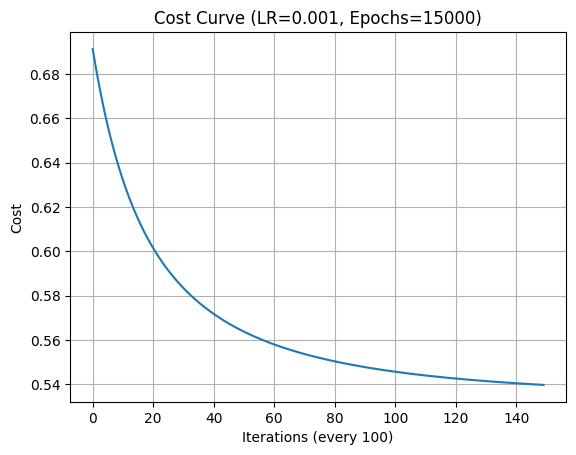

Final Train Accuracy: 0.7357
Final Test Accuracy : 0.7297


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
np.random.seed(42)

# 1. Load and preprocess the dataset
df = pd.read_csv('allwine.csv')
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
            'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
X = df[features].values
y = df['quality'].values.reshape(-1, 1)

# Binary classification (if not already)
if len(np.unique(y)) > 2:
    y = (y >= 6).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2. Logistic Regression Functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def initialize(n):
    w = np.random.randn(1, n) * 0.01
    b = np.random.randn() * 0.01
    return w, b

def optimize(w, b, X, Y):
    m = X.shape[0]
    z = np.dot(w, X.T) + b
    a = sigmoid(z)
    cost = -np.mean(Y.T * np.log(a + 1e-9) + (1 - Y.T) * np.log(1 - a + 1e-9))
    dw = np.dot((a - Y.T), X) / m
    db = np.sum(a - Y.T) / m
    return dw, db, cost

def train(X, Y, lr, epochs):
    w, b = initialize(X.shape[1])
    costs = []
    for i in range(epochs):
        dw, db, cost = optimize(w, b, X, Y)
        w -= lr * dw
        b -= lr * db
        if i % 100 == 0:
            costs.append(cost)
    return w, b, costs

def predict(w, b, X):
    z = np.dot(w, X.T) + b
    a = sigmoid(z)
    return (a > 0.5).astype(int)

# 3. Grid Search
lr_list = [0.01, 0.001, 0.0001, 0.03, 0.003, 0.0003, 0.05, 0.005, 0.0005]
iter_list = [5000, 10000, 15000]

best_accuracy = 0
best_lr = None
best_iter = None
best_w = None
best_b = None
results = []

for lr in lr_list:
    for epochs in iter_list:
        
        w, b, _ = train(X_train, y_train, lr=lr, epochs=epochs)
        y_test_pred = predict(w, b, X_test).reshape(-1, 1)
        acc = accuracy_score(y_test, y_test_pred)
        results.append((lr, epochs, acc))
        

        if (acc > best_accuracy) or (acc == best_accuracy and epochs < best_iter):
          best_accuracy = acc
          best_lr = lr
          best_iter = epochs
          best_w = w
          best_b = b

# 4. Report Best
print("=====================================")
print("Best Hyperparameter Combination:")
print(f"Learning Rate: {best_lr}")
print(f"Epochs: {best_iter}")
print(f"Test Accuracy: {round(best_accuracy, 4)}")
print("=====================================\n")

# 5. Train again for cost curve
_, _, best_costs = train(X_train, y_train, lr=best_lr, epochs=best_iter)

plt.plot(best_costs)
plt.title(f"Cost Curve (LR={best_lr}, Epochs={best_iter})")
plt.xlabel("Iterations (every 100)")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

# 6. Evaluate on Train and Test Sets
y_train_pred = predict(best_w, best_b, X_train).reshape(-1, 1)
y_test_pred = predict(best_w, best_b, X_test).reshape(-1, 1)

print("Final Train Accuracy:", round(accuracy_score(y_train, y_train_pred), 4))
print("Final Test Accuracy :", round(accuracy_score(y_test, y_test_pred), 4))


# Task 2 : Implement the above dynamic ensemble logistic regression model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
np.random.seed(42)

# Load data
df = pd.read_csv('allwine.csv')
features = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
    'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'
]
X = df[features].values
y = df['quality'].values  # Binary (0/1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ensemble Logistic Regression
class SimpleEnsembleLR:
    def __init__(self, lr=0.03, num_iter=2000):
        self.lr = lr
        self.num_iter = num_iter

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        n, d = X.shape
        self.w_m = np.zeros(d)
        self.b_m = 0
        self.w_l = np.zeros(d)
        self.b_l = 0
        self.w_r = np.zeros(d)
        self.b_r = 0

        for i in range(self.num_iter):
            z_m = np.dot(X, self.w_m) + self.b_m
            p_m = self.sigmoid(z_m)
            z_l = np.dot(X, self.w_l) + self.b_l
            p_l = self.sigmoid(z_l)
            z_r = np.dot(X, self.w_r) + self.b_r
            p_r = self.sigmoid(z_r)

            p_left = p_m * p_l + (1 - p_m) * p_r
            p_left = np.clip(p_left, 1e-9, 1 - 1e-9)

            dL = -(y / p_left) + ((1 - y) / (1 - p_left))

            grad_zm = (p_l - p_r) * p_m * (1 - p_m)
            grad_wm = np.dot(dL * grad_zm, X) / n
            grad_bm = np.mean(dL * grad_zm)

            grad_zl = p_m * p_l * (1 - p_l)
            grad_wl = np.dot(dL * grad_zl, X) / n
            grad_bl = np.mean(dL * grad_zl)

            grad_zr = (1 - p_m) * p_r * (1 - p_r)
            grad_wr = np.dot(dL * grad_zr, X) / n
            grad_br = np.mean(dL * grad_zr)

            self.w_m -= self.lr * grad_wm
            self.b_m -= self.lr * grad_bm
            self.w_l -= self.lr * grad_wl
            self.b_l -= self.lr * grad_bl
            self.w_r -= self.lr * grad_wr
            self.b_r -= self.lr * grad_br

    def predict(self, X):
        z_m = np.dot(X, self.w_m) + self.b_m
        p_m = self.sigmoid(z_m)
        z_l = np.dot(X, self.w_l) + self.b_l
        p_l = self.sigmoid(z_l)
        z_r = np.dot(X, self.w_r) + self.b_r
        p_r = self.sigmoid(z_r)
        p_left = p_m * p_l + (1 - p_m) * p_r
        return (p_left >= 0.5).astype(int)

# ---------- Auto-tuning section ----------
lr_list = [0.01, 0.001, 0.0001, 0.03, 0.003, 0.0003, 0.05, 0.005, 0.0005]
iter_list = [5000, 10000, 15000]
best_acc = 0
best_config = None
results = []

for lr in lr_list:
    for num_iter in iter_list:
        model = SimpleEnsembleLR(lr=lr, num_iter=num_iter)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append((lr, num_iter, acc))

        # Update best config (prefer fewer epochs if acc is equal)
        if (acc > best_acc) or (acc == best_acc and (best_config is None or num_iter < best_config[1])):
            best_acc = acc
            best_config = (lr, num_iter)

# ---------- Train final model with best config ----------
final_model = SimpleEnsembleLR(lr=best_config[0], num_iter=best_config[1])
final_model.fit(X_train, y_train)
final_preds = final_model.predict(X_test)

print(f"\n Best Test Accuracy: {best_acc:.4f} with lr={best_config[0]}, iterations={best_config[1]}")




 Best Test Accuracy: 0.7297 with lr=0.003, iterations=10000


# Task 3 : Continue the research on deep dynamic ensemble model

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
np.random.seed(42)

# Load and preprocess data
df = pd.read_csv("allwine.csv")
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
            'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
X = df[features].values
y = df['quality'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.T  # (features, samples)
X_test = X_test.T
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

class ThreeLayerEnsemble:
    def __init__(self):
        self.weights = [np.zeros(X_train.shape[0]) for _ in range(7)]
        self.biases = [0.0 for _ in range(7)]

    def forward_all(self, X):
        return [sigmoid(np.dot(w, X) + b) for w, b in zip(self.weights, self.biases)]

    def forward_final(self, h):
        h1, h2, h3, h4, h5, h6, h7 = h
        return (h1 * h2 * h4 +
                h1 * (1 - h2) * h5 +
                (1 - h1) * h3 * h6 +
                (1 - h1) * (1 - h3) * h7)

    def fit(self, X, y, lr=0.01, num_iter=3000):
        m = X.shape[1]
        for it in range(num_iter):
            h = self.forward_all(X)
            p = self.forward_final(h)
            eps = 1e-8
            loss = -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))

            grad = (p - y)  # shape (1, m)

            # Node-wise gradients
            dh = [
                grad * (h[1] * h[3] - h[1] * h[4] - h[2] * h[5] + h[2] * h[6]),  # dh1
                grad * h[0] * (h[3] - h[4]),                                     # dh2
                grad * (1 - h[0]) * (h[5] - h[6]),                               # dh3
                grad * h[0] * h[1],                                              # dh4
                grad * h[0] * (1 - h[1]),                                        # dh5
                grad * (1 - h[0]) * h[2],                                        # dh6
                grad * (1 - h[0]) * (1 - h[2])                                   # dh7
            ]

            for i in range(7):
                h_i = h[i]
                d_act = dh[i] * h_i * (1 - h_i)
                grad_w = np.dot(X, d_act.T.reshape(1, -1).T).flatten() / m
                grad_b = np.mean(d_act)

                self.weights[i] -= lr * grad_w
                self.biases[i] -= lr * grad_b

    def predict(self, X):
        h = self.forward_all(X)
        p = self.forward_final(h)
        return (p >= 0.5).astype(int)

# ---------- Smart Auto-Tuning ----------
lr_list = [0.01, 0.001, 0.0001, 0.03, 0.003, 0.0003, 0.05, 0.005, 0.0005]
iter_list = [5000, 10000, 15000]

best_acc = 0
best_config = None
results = []

for lr in lr_list:
    for iters in iter_list:
        model = ThreeLayerEnsemble()
        model.fit(X_train, y_train, lr=lr, num_iter=iters)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test.flatten(), y_pred.flatten())
        results.append((lr, iters, acc))

        # Update best config (prefer fewer epochs when acc is equal)
        if (acc > best_acc) or (acc == best_acc and (best_config is None or iters < best_config[1])):
            best_acc = acc
            best_config = (lr, iters)

# ---------- Final Training with Best Config ----------
final_model = ThreeLayerEnsemble()
final_model.fit(X_train, y_train, lr=best_config[0], num_iter=best_config[1])
final_preds = final_model.predict(X_test)

print(f"\n Best Test Accuracy: {best_acc:.4f} with lr={best_config[0]}, iterations={best_config[1]}")



 Best Test Accuracy: 0.7297 with lr=0.05, iterations=5000


# Task 4 (Bonus) Generalize your model to support arbitrary number of layers

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

np.random.seed(42)
# ----------- Step 1: User Inputs -----------
try:
    n_layers = int(input("Enter number of layers (e.g. 3, 4, 5): "))
    lr = float(input("Enter learning rate (e.g. 0.01, 0.005, 0.001): "))
    num_iter = int(input("Enter number of iterations (e.g. 5000, 10000, 20000): "))
except ValueError:
    print(" Invalid input. Using default values: n_layers=5, lr=0.05, num_iter=30000")
    n_layers = 5
    lr = 0.05
    num_iter = 30000

# ----------- Step 2: Load Dataset -----------
df = pd.read_csv("allwine.csv")
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
            'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
X = df[features].values
y = df['quality'].values

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ----------- Step 3: Deep Ensemble Logistic Regression Class -----------
class DeepEnsembleLogisticRegression:
    def __init__(self, n_layers, lr=0.001, num_iter=5000):
        self.n_layers = n_layers
        self.lr = lr
        self.num_iter = num_iter

    def sigmoid(self, z):
        z = np.clip(z, -500, 500)  # prevent overflow
        return 1 / (1 + np.exp(-z))

    def build_tree(self, n_features):
        self.total_nodes = 2 ** self.n_layers - 1
        self.first_leaf = 2 ** (self.n_layers - 1)
        self.thetas = [np.random.randn(n_features) * 0.01 for _ in range(self.total_nodes)]
        self.biases = [0.0 for _ in range(self.total_nodes)]

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.build_tree(n_features)

        for it in range(self.num_iter):
            probs = []
            for i in range(self.total_nodes):
                z = np.dot(X, self.thetas[i]) + self.biases[i]
                probs.append(self.sigmoid(z))

            p_final = np.zeros(n_samples)
            for leaf in range(self.first_leaf - 1, self.total_nodes):
                path = []
                cur = leaf + 1
                while cur > 1:
                    parent = cur // 2
                    direction = 'left' if cur % 2 == 0 else 'right'
                    path.append((parent - 1, direction))
                    cur = parent
                path = path[::-1]

                prob_path = np.ones(n_samples)
                for node, direction in path:
                    if direction == 'left':
                        prob_path *= probs[node]
                    else:
                        prob_path *= (1 - probs[node])
                p_final += prob_path * probs[leaf]

            # Compute loss
            eps = 1e-9
            p_final = np.clip(p_final, eps, 1 - eps)
            loss = -np.mean(y * np.log(p_final) + (1 - y) * np.log(1 - p_final))

            # Gradient
            dL_dp = (p_final - y)

            grads_theta = [np.zeros_like(self.thetas[i]) for i in range(self.total_nodes)]
            grads_bias = [0.0 for _ in range(self.total_nodes)]

            for leaf in range(self.first_leaf - 1, self.total_nodes):
                cur = leaf + 1
                path = []
                while cur > 1:
                    parent = cur // 2
                    direction = 'left' if cur % 2 == 0 else 'right'
                    path.append((parent - 1, direction))
                    cur = parent
                path = path[::-1]

                prob_path = np.ones(n_samples)
                for node, direction in path:
                    if direction == 'left':
                        prob_path *= probs[node]
                    else:
                        prob_path *= (1 - probs[node])

                # Gradient for the leaf
                d_output = dL_dp * prob_path * probs[leaf] * (1 - probs[leaf])
                grads_theta[leaf] += np.dot(X.T, d_output) / n_samples
                grads_bias[leaf] += np.mean(d_output)

                # Gradient for internal nodes along the path
                for node, direction in path:
                    other_path = np.ones(n_samples)
                    for node2, dir2 in path:
                        if node2 == node:
                            break
                        if dir2 == 'left':
                            other_path *= probs[node2]
                        else:
                            other_path *= (1 - probs[node2])
                    if direction == 'left':
                        grad_input = dL_dp * probs[leaf] * other_path * probs[node] * (1 - probs[node])
                    else:
                        grad_input = -dL_dp * probs[leaf] * other_path * probs[node] * (1 - probs[node])
                    grads_theta[node] += np.dot(X.T, grad_input) / n_samples
                    grads_bias[node] += np.mean(grad_input)

            # Update weights and biases
            for i in range(self.total_nodes):
                self.thetas[i] -= self.lr * grads_theta[i]
                self.biases[i] -= self.lr * grads_bias[i]

            if it % 500 == 0:
                print(f"Step {it}, Loss: {round(loss, 5)}")

    def predict(self, X):
        n_samples = X.shape[0]
        probs = []
        for i in range(self.total_nodes):
            z = np.dot(X, self.thetas[i]) + self.biases[i]
            probs.append(self.sigmoid(z))

        p_final = np.zeros(n_samples)
        for leaf in range(self.first_leaf - 1, self.total_nodes):
            cur = leaf + 1
            path = []
            while cur > 1:
                parent = cur // 2
                direction = 'left' if cur % 2 == 0 else 'right'
                path.append((parent - 1, direction))
                cur = parent
            path = path[::-1]

            prob_path = np.ones(n_samples)
            for node, direction in path:
                if direction == 'left':
                    prob_path *= probs[node]
                else:
                    prob_path *= (1 - probs[node])
            p_final += prob_path * probs[leaf]

        return (p_final >= 0.5).astype(int)

# ----------- Step 4: Train and Evaluate -----------
model = DeepEnsembleLogisticRegression(n_layers=n_layers, lr=lr, num_iter=num_iter)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n Test Accuracy: {round(acc, 4)} with n_layers={n_layers}, lr={lr}, iterations={num_iter}")


Enter number of layers (e.g. 3, 4, 5):  3
Enter learning rate (e.g. 0.01, 0.005, 0.001):  0.05
Enter number of iterations (e.g. 5000, 10000, 20000):  15000


Step 0, Loss: 0.69495
Step 500, Loss: 0.61507
Step 1000, Loss: 0.58497
Step 1500, Loss: 0.56962
Step 2000, Loss: 0.56034
Step 2500, Loss: 0.55415
Step 3000, Loss: 0.54974
Step 3500, Loss: 0.54645
Step 4000, Loss: 0.5439
Step 4500, Loss: 0.54183
Step 5000, Loss: 0.5401
Step 5500, Loss: 0.53859
Step 6000, Loss: 0.53722
Step 6500, Loss: 0.53594
Step 7000, Loss: 0.5347
Step 7500, Loss: 0.53348
Step 8000, Loss: 0.53226
Step 8500, Loss: 0.53103
Step 9000, Loss: 0.52978
Step 9500, Loss: 0.52854
Step 10000, Loss: 0.5273
Step 10500, Loss: 0.52608
Step 11000, Loss: 0.52491
Step 11500, Loss: 0.52377
Step 12000, Loss: 0.52268
Step 12500, Loss: 0.52165
Step 13000, Loss: 0.52066
Step 13500, Loss: 0.51973
Step 14000, Loss: 0.51885
Step 14500, Loss: 0.51803

 Test Accuracy: 0.7438 with n_layers=3, lr=0.05, iterations=15000
